In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf

2022-06-17 10:35:36.767791: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.__version__

'2.3.0'

In [3]:
s=384

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [5]:
def build_model(num_classes):
    inputs = layers.Input(shape=(s, s, 3))
    x = inputs
    model = EfficientNetB4(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable =True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [6]:
from tensorflow.keras.applications import EfficientNetB4
#with strategy.scope():
model = build_model(num_classes=1)
print(model.summary())

2022-06-17 10:35:41.916350: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-17 10:35:41.986632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-17 10:35:41.987792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-17 10:35:41.988972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 384, 384, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 384, 384, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 385, 385, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [7]:
model.load_weights('weights/last/effb4_cls_last.h5')

# Training after liver detection

In [8]:
import efficientnet

In [9]:
import os 
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# resizing the image
Size_X =240
Size_Y =240
n_classes = 2

In [11]:

import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `tf.keras` framework.


In [13]:
model2 = sm.PSPNet(BACKBONE, encoder_weights = None, classes =3 ,encoder_freeze=False, activation='softmax',input_shape=(Size_X,Size_Y,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.2)
#model2 = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes =3 ,encoder_freeze=False,input_shape=(256,256,3),activation='softmax')
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),loss=sm.losses.cce_jaccard_loss, metrics=[sm.metrics.IOUScore(class_indexes=2),sm.metrics.FScore(class_indexes=2),sm.metrics.Precision(class_indexes=2),sm.metrics.Recall(class_indexes=2)])
print(model2.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 120, 120, 48) 1296        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 120, 120, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 120, 120, 48) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [23]:
model2.load_weights('weights/last/effb4_240fi.h5')

(1, 240, 240, 3)
inference time is:62.89386749267578ms


[]

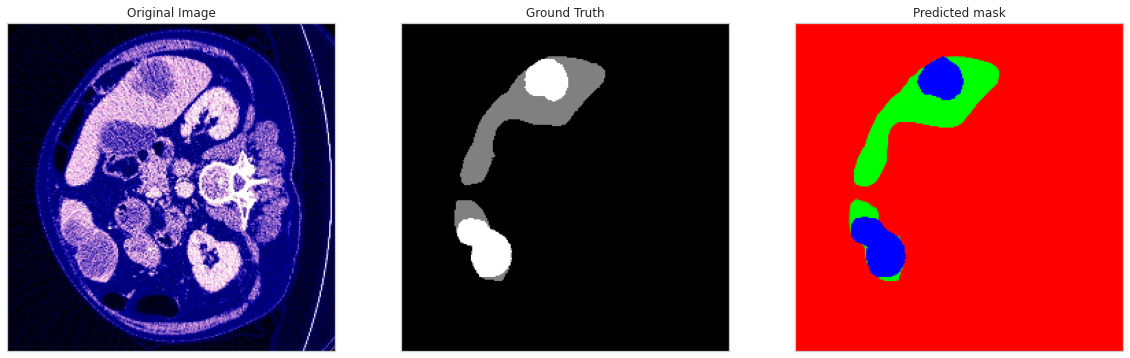

In [24]:
import time
#Test on a different image
#READ EXTERNAL IMAGE...
start =time.time()
test_img = cv2.imread('new/train_img_1/liver/volume-129_slice_104.jpg', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (Size_Y, Size_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img1 = np.expand_dims(test_img, axis=0)
print(test_img1.shape)
prediction = model2.predict(test_img1)
img=prediction.reshape((Size_Y, Size_X,3))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
end=time.time()
inference=(end-start)*1000
print("inference time is:"+str(inference)+"ms")

mask_img = cv2.imread('new/train_img_1/liver_mask/segmentation-129_slice_104.tiff',0)       
mask_img = cv2.resize(mask_img, (Size_Y, Size_X))
fig, ax= plt.subplots(1,3,figsize=(20, 20))
ax[0].imshow(test_img, cmap='gray')
ax[0].set(title='Original Image')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].imshow(mask_img, cmap='gray')
ax[1].set(title='Ground Truth')
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[2].imshow(img, cmap='gray')
ax[2].set(title='Predicted mask')
ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])

In [27]:
import cv2
import imageio
import skimage.transform as skTrans
from nilearn.image import resample_img
import nibabel as nib
from tqdm import tqdm
from PIL import Image
from ipywidgets import *

In [28]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    #array   = np.array(array)
    array   = np.rot90(np.array(array))
    return(array, ct_scan)

In [29]:
import fastai; fastai.__version__
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [30]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

In [31]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

In [38]:
@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    #im=im.convert('BGR')
    #im = ImageOps.mirror(im.rotate(angle = 180))
    im = im.rotate(angle = -90)
    im = im.resize((384,384))
    im= np.array(im)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    return im
    #im.save(fn, quality=quality)

In [34]:
def gray2(mask):
    res=np.zeros((mask.shape[0],mask.shape[1]))
    for i in range (0,mask.shape[0]):
        for j in range (0,mask.shape[1]):
            l=np.argmax([mask[i,j,0],mask[i,j,1],mask[i,j,2]])
            res[i,j]=l
    res=res.astype(np.uint8)
    #res = cv2.resize(res, (512, 512))
    return res

In [35]:
vol_list = []
mask_list = []
for filename in sorted(os.listdir('new/train_data/vol')):
    vol_list.append(filename)
df_files = pd.DataFrame(vol_list,columns=['volname'])

print(df_files.head(60))

           volname
0     volume-0.nii
1     volume-1.nii
2    volume-10.nii
3   volume-100.nii
4   volume-101.nii
5   volume-102.nii
6   volume-103.nii
7   volume-104.nii
8   volume-105.nii
9   volume-106.nii
10   volume-11.nii
11  volume-111.nii
12  volume-112.nii
13  volume-113.nii
14  volume-114.nii
15  volume-115.nii
16  volume-116.nii
17  volume-117.nii
18  volume-118.nii
19  volume-119.nii
20   volume-12.nii
21  volume-120.nii
22  volume-121.nii
23  volume-122.nii
24  volume-123.nii
25  volume-128.nii
26  volume-129.nii
27   volume-13.nii
28  volume-130.nii
29   volume-14.nii
30   volume-15.nii
31   volume-16.nii
32   volume-17.nii
33   volume-18.nii
34   volume-19.nii
35    volume-2.nii
36   volume-20.nii
37   volume-21.nii
38   volume-26.nii
39   volume-27.nii
40   volume-28.nii
41   volume-29.nii
42    volume-3.nii
43   volume-30.nii
44   volume-31.nii
45   volume-32.nii
46   volume-33.nii
47   volume-34.nii
48   volume-35.nii
49   volume-36.nii
50   volume-37.nii
51   volume-

In [39]:
rows = len(df_files)
dir_path = 'new/train_data/vol/'
for i in range(52,53):
  vol_path=os.path.join(dir_path+df_files['volname'][i])
  curr_ct, nifimg = read_nii(vol_path)
  curr_dim = curr_ct.shape[2]
  res_mask=np.zeros(curr_ct.shape)
    
  #file_name = str(df_files.loc[i,'volname']).split('-')[2]
  #number = str(file_name).split('.')[0]
    
  for curr_slice in range(0,curr_dim):
    data = tensor(curr_ct[...,curr_slice].astype(np.float32))
    img = data.save_jpg(f"new/test/test_frames/_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])     
    img1 = np.array(img)
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img1 = cv2.resize(img1,(240,240))
    img1 = np.expand_dims(img1, axis=0)
    img = np.expand_dims(img, axis=0)
    pred1 = model.predict(img)
    if(pred1>0.5):
        print(curr_slice)
        pred = model2.predict(img1)
        mas=pred.reshape((Size_Y,Size_X,3))
        mas=cv2.resize(mas,(512,512))
        mas=gray2(mas)
        res_mask[...,curr_slice]=mas
  
  res_mask = np.array(res_mask)
  res_mask = res_mask.astype(np.uint8)
  clip = nib.Nifti1Image(res_mask, nifimg.affine, nifimg.header)
  clip.set_data_dtype(np.uint8)
  nib.save(clip, f"new/res/test-segmentation-res.nii")
  print(np.unique(res_mask))
  print('completed'+str(i))

335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
